In [8]:
from scapy.all import sniff, IP
import pandas as pd

In [9]:
# Replace 'en0' with the interface you identified using ifconfig
INTERFACE = 'en0'

packets_data = []  # List to store packet info

def packet_callback(packet):
    """Callback function to process each packet"""
    if IP in packet:  # Check if it's an IP packet
        packet_info = {
            'timestamp': packet.time,
            'source_ip': packet[IP].src,
            'destination_ip': packet[IP].dst,
            'protocol': packet.sprintf("%IP.proto%"),
            'length': len(packet)
        }
        packets_data.append(packet_info)

def start_sniffing(interface=INTERFACE, packet_count=100):
    """Start packet sniffing on the specified interface"""
    print(f"Starting packet sniffing on {interface}... (Press CTRL+C to stop)")
    sniff(iface=interface, prn=packet_callback, count=packet_count)

def save_packets_to_csv(file_name='captured_packets.csv'):
    """Save captured packets to a CSV file"""
    df_packets = pd.DataFrame(packets_data)
    df_packets.to_csv(file_name, index=False)
    print(f"Saved captured packets to {file_name}")

if __name__ == "__main__":
    start_sniffing()
    save_packets_to_csv()

Starting packet sniffing on en0... (Press CTRL+C to stop)
Saved captured packets to captured_packets.csv


      timestamp     source_ip destination_ip protocol  length
0  1.712587e+09  192.168.1.79   17.250.81.68      tcp      90
1  1.712587e+09  192.168.1.79   17.250.81.68      tcp      66
2  1.712587e+09  17.250.81.68   192.168.1.79      tcp      78
3  1.712587e+09  17.250.81.68   192.168.1.79      tcp      66
4  1.712587e+09  17.250.81.68   192.168.1.79      tcp      66
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       97 non-null     float64
 1   source_ip       97 non-null     object 
 2   destination_ip  97 non-null     object 
 3   protocol        97 non-null     object 
 4   length          97 non-null     int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 3.9+ KB
None
          timestamp       length
count  9.700000e+01    97.000000
mean   1.712587e+09   282.577320
std    1.471779e+00   449.814889
min    1.712

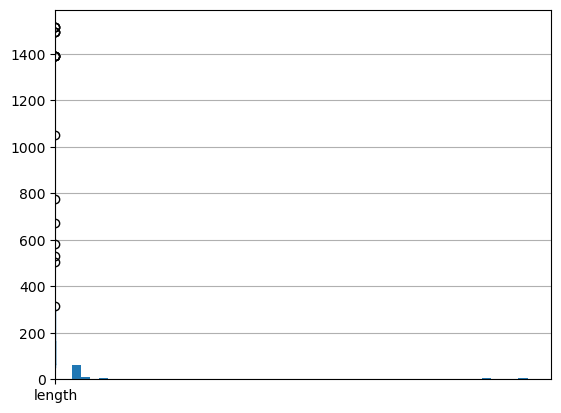

In [10]:
# Load the dataset
df = pd.read_csv('captured_packets.csv')

# Display the first few rows of the dataset
print(df.head())

# Get a concise summary of the DataFrame
print(df.info())

# Basic statistics for numerical columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Remove duplicate rows
df = df.drop_duplicates()

# Histogram of packet lengths
df['length'].hist(bins=50)

# Count of packets by protocol
print(df['protocol'].value_counts())

# Boxplot for packet length can help identify outliers
df.boxplot(column=['length'])

import pandas as pd

# Assuming 'timestamp' is in UNIX time format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

# Optionally, you can create a feature for the time of day (morning, afternoon, evening)
df['time_of_day'] = pd.cut(df['hour'], 
                           bins=[0, 6, 12, 18, 24], 
                           include_lowest=True, 
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'])

In [11]:
# Function to check if an IP address is private
def is_private_ip(ip):
    if ip.startswith('10.') or ip.startswith('192.168.') or ip.startswith('172.'):
        return 'Private'
    else:
        return 'Public'

# Apply the function to source and destination IP addresses
df['source_ip_type'] = df['source_ip'].apply(is_private_ip)
df['destination_ip_type'] = df['destination_ip'].apply(is_private_ip)

# Create a unique identifier for each flow based on IP addresses
df['flow_id'] = df.apply(lambda row: '_'.join(sorted([row['source_ip'], row['destination_ip']])), axis=1)

# Count packets in each flow
df['flow_packet_count'] = df.groupby('flow_id')['timestamp'].transform('count')

# Average packet size in each flow
df['flow_avg_packet_size'] = df.groupby('flow_id')['length'].transform('mean')

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming df is your DataFrame and it has been preprocessed
X = df.drop(['target_column'], axis=1)  # Replace 'target_column' with your actual target column name
y = df['target_column']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

from sklearn.model_selection import train_test_split

# Assuming X (features) and y (target) are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

KeyError: "['target_column'] not found in axis"

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validated Accuracy:", scores.mean())